In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import sys
sys.path.append("../../")
from pybmix.core.mixing import PythonMixing, DirichletProcessMixing
from pybmix.core.hierarchy import PythonHierarchy, UnivariateNormal
from pybmix.core.mixture_model import MixtureModel
from pybmix.estimators.density_estimator import DensityEstimator

In [2]:
np.random.seed(2022)

## Generate data as mixture of two Normals

$$
y_i \sim \frac{7}{10} \mathcal N(-3, 1) + \frac{3}{10} \mathcal N(3, 1), \quad i=1, \ldots, 200
$$

In [3]:
def sample_from_mixture_norm(weights, means, sds, n_data):
    n_comp = len(weights)
    clus_alloc = np.random.choice(np.arange(n_comp), p=weights, size=n_data)
    return np.random.normal(loc=means[clus_alloc], scale=sds[clus_alloc])

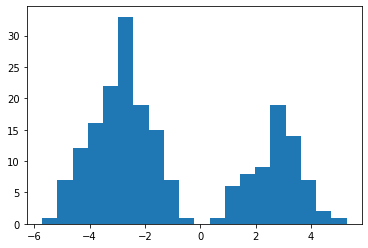

In [4]:
y_norm = sample_from_mixture_norm(
    np.array([0.7, 0.3]), np.array([-3, 3]), np.array([1, 1]), 200)
plt.hist(y_norm, bins=20)
plt.show()

## NNIG Hierarchy and DP Mixing in Python

In [5]:
mixing_py = PythonMixing("DP_mixing")
hierarchy_py = PythonHierarchy("NNIG_Hierarchy_fixed_values")

In [6]:
mixture_py = MixtureModel(mixing_py, hierarchy_py)

In [7]:
niter = 500
nburn = 100
algo = "Neal2"

In [8]:
mixture_py.run_mcmc(y_norm, algorithm=algo, niter=niter, nburn=nburn)

Using hierarchy implementation in NNIG_Hierarchy_fixed_values.py
Using mixing implementation in: DP_mixing.py
Initializing... Done
Running Neal2 algorithm with PythonHier hierarchies, PythonMix mixing...
===========>                                               ] 20% 19.482s[============>                                               ] 20% 19.86s[============>                                               ] 21% 20.094s[=============>                                              ] 21% 20.477s[=============>                                              ] 22% 20.883s[=============>                                              ] 22% 21.31s[=============>                                              ] 23% 21.651s[==============>                                             ] 23% 21.999s[==============>                                             ] 23% 22.357s[==============>                                             ] 24% 22.757s[==============>                                            

In [9]:
grid = np.linspace(-8, 8, 200)
dens_est_py = DensityEstimator(mixture_py)
densities_py = dens_est_py.estimate_density(grid)

[============================================================] 100% 64.753s==================>                                         ] 30% 20.093s[==================>                                         ] 30% 20.414s[==================>                                         ] 31% 20.774s[===================>                                        ] 31% 21.138s[===================>                                        ] 32% 21.713s[===================>                                        ] 33% 21.946s[====================>                                       ] 33% 22.324s[====================>                                       ] 34% 22.751s[====================>                                       ] 34% 23.063s[=====================>                                      ] 34% 23.304s[=====================>                                      ] 35% 23.646s[=====================>                                      ] 36% 24.007s[=====================>               

## NNIG Hierarchy and DP Mixing in C++

In [10]:
mixing_cpp = DirichletProcessMixing(total_mass=5)
hierarchy_cpp = UnivariateNormal()
hierarchy_cpp.make_default_fixed_params(y_norm, 2)

In [11]:
mixture_cpp = MixtureModel(mixing_cpp, hierarchy_cpp)

In [12]:
niter = 500
nburn = 100
algo = "Neal2"

In [13]:
mixture_cpp.run_mcmc(y_norm, algorithm=algo, niter=niter, nburn=nburn)

Initializing... Done
Running Neal2 algorithm with NNIG hierarchies, DP mixing...
===========>                                               ] 20% 0.1s[============>                                               ] 20% 0.102s[============>                                               ] 20% 0.102s[============>                                               ] 21% 0.103s[============>                                               ] 21% 0.104s[=============>                                              ] 21% 0.105s[=============>                                              ] 22% 0.107s[=============>                                              ] 22% 0.108s[=============>                                              ] 23% 0.109s[==============>                                             ] 23% 0.11s[==============>                                             ] 23% 0.113s[==============>                                             ] 24% 0.114s[==============>                                

In [14]:
# grid = np.linspace(-8, 8, 200)
dens_est_cpp = DensityEstimator(mixture_cpp)
densities_cpp = dens_est_cpp.estimate_density(grid)

[======================>                                     ] 37% 0.014s

## Comparing the density estimations for Python and C++ implementations of the models

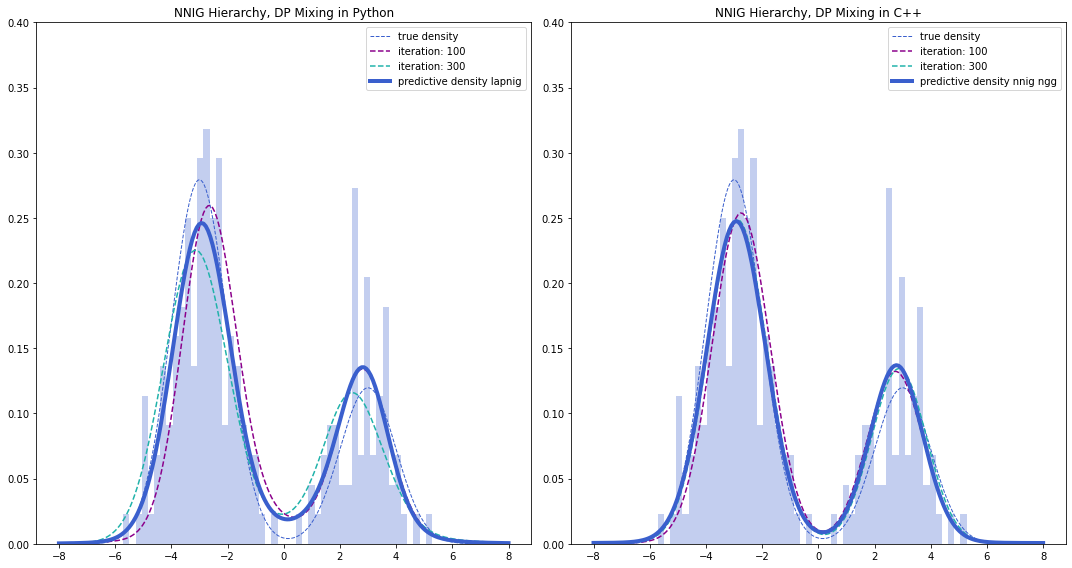

In [16]:
fig, axes = plt.subplots(1,2, figsize=(15,8))

axes[0].set_ylim(0, 0.4)
axes[1].set_ylim(0, 0.4)

axes[0].hist(y_norm, density=True, bins=50, alpha=0.3, color="#3A5FCD")
axes[0].plot(np.linspace(-8, 8, 1000), 0.7*ss.norm.pdf(np.linspace(-8, 8, 1000), -3, 1) + 0.3*ss.norm.pdf(np.linspace(-8, 8, 1000), 3, 1),
             "--", lw=1, color="#3A5FCD", label="true density")
axes[1].hist(y_norm, density=True, bins=50, alpha=0.3, color="#3A5FCD")
axes[1].plot(np.linspace(-8, 8, 1000), 0.7*ss.norm.pdf(np.linspace(-8, 8, 1000), -3, 1) + 0.3*ss.norm.pdf(np.linspace(-8, 8, 1000), 3, 1),
             "--", lw=1, color="#3A5FCD", label="true density")

idxs = [int((niter - nburn) * 0.25), int((niter - nburn) * 0.75)]
colors = ["#8B008B", "#20B2AA"]
for i, idx in enumerate(idxs):
    axes[0].plot(grid, densities_py[idx, :], "--", label="iteration: {0}".format(idx), color = colors[i])
    axes[1].plot(grid, densities_cpp[idx, :], "--", label="iteration: {0}".format(idx), color = colors[i])

axes[0].plot(grid, np.mean(densities_py, axis=0), lw=4, label="predictive density lapnig", color="#3A5FCD")
axes[1].plot(grid, np.mean(densities_cpp, axis=0), lw=4, label="predictive density nnig ngg", color="#3A5FCD")

axes[0].legend()
axes[1].legend()

axes[0].set_title("NNIG Hierarchy, DP Mixing in Python")
axes[1].set_title("NNIG Hierarchy, DP Mixing in C++")

plt.tight_layout()
plt.show()